In [132]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

### Creating a one bus for the Netherlands

In [133]:
network = pypsa.Network()
hours_in_2023 = pd.date_range('2017-01-01 00:00Z',
                              '2017-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2023.values)

network.add("Bus",
            "electricity bus")

network.snapshots

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2017-12-31 14:00:00', '2017-12-31 15:00:00',
               '2017-12-31 16:00:00', '2017-12-31 17:00:00',
               '2017-12-31 18:00:00', '2017-12-31 19:00:00',
               '2017-12-31 20:00:00', '2017-12-31 21:00:00',
               '2017-12-31 22:00:00', '2017-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

#### Getting the demand for the Netherlands and adding it to the bus

In [134]:
# Define file path
file_path = "Data\demand_data.csv"

# Load dataset
data = pd.read_csv(file_path, sep=';', parse_dates=['utc_timestamp'], index_col='utc_timestamp')

# Rename columns (if necessary)
data.columns = [
    'cet_cest_timestamp', 'NL_load_actual_entsoe_transparency',
    'NL_load_forecast_entsoe_transparency', 'NL_solar_generation_actual',
    'NL_wind_generation_actual', 'NL_wind_offshore_generation_actual',
    'NL_wind_onshore_generation_actual'
]

# Convert index to datetime format
data.index = pd.to_datetime(data.index, utc=True)

start_date = '2017-01-01 00:00:00+00:00'
end_date = '2017-12-31 23:00:00+00:00'

data = data[start_date:end_date]
print(data.head())
country = 'NLD'

<>:2: SyntaxWarning:

invalid escape sequence '\d'

<>:2: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\Change\AppData\Local\Temp\ipykernel_34160\2064595465.py:2: SyntaxWarning:

invalid escape sequence '\d'



                                 cet_cest_timestamp  \
utc_timestamp                                         
2017-01-01 00:00:00+00:00  2017-01-01T01:00:00+0100   
2017-01-01 01:00:00+00:00  2017-01-01T02:00:00+0100   
2017-01-01 02:00:00+00:00  2017-01-01T03:00:00+0100   
2017-01-01 03:00:00+00:00  2017-01-01T04:00:00+0100   
2017-01-01 04:00:00+00:00  2017-01-01T05:00:00+0100   

                           NL_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2017-01-01 00:00:00+00:00                             10794.0   
2017-01-01 01:00:00+00:00                             10320.0   
2017-01-01 02:00:00+00:00                              9930.0   
2017-01-01 03:00:00+00:00                              9679.0   
2017-01-01 04:00:00+00:00                              9652.0   

                           NL_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2017-01-01 00:00:00+00:0

In [135]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=data['NL_load_actual_entsoe_transparency'].values)

Index(['load'], dtype='object')

In [136]:
network.loads_t.p_set

Load,load
snapshot,
2017-01-01 00:00:00,10794.0
2017-01-01 01:00:00,10320.0
2017-01-01 02:00:00,9930.0
2017-01-01 03:00:00,9679.0
2017-01-01 04:00:00,9652.0
...,...
2017-12-31 19:00:00,12703.0
2017-12-31 20:00:00,11961.0
2017-12-31 21:00:00,11478.0


#### Adding different generation types 

In [137]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
print(annuity(25,0.07))
print(annuity(25,0.07)*425000*(1+0.03))

0.0858105172206656
37563.55391334636


In [138]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in /MWh_tt_CO2h
network.add("Carrier", "coal", co2_emissions=0.3) # in /MWh_tt_CO2h
network.add("Carrier", "offshorewind")
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values)

# add offshore wind generator
df_offshorewind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
CF_wind = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshorewind = annuity(30,0.07)*1000000*(1+0.033) # in €/MW
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values)

# add solar PV generator
df_solar = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)


# add coal power plant  generator
capital_cost_coal = annuity(30,0.07)*700000*(1+0.033) # in €/MW
fuel_cost = 30 # in €/MWh_th
efficiency = 0.42 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            marginal_cost = marginal_cost_coal)

Index(['coal'], dtype='object')

In [139]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2017-01-01 00:00:00,0.691,0.350,0.0
2017-01-01 01:00:00,0.732,0.377,0.0
2017-01-01 02:00:00,0.743,0.385,0.0
2017-01-01 03:00:00,0.748,0.400,0.0
2017-01-01 04:00:00,0.734,0.406,0.0
...,...,...,...
2017-12-31 19:00:00,0.711,0.468,0.0
2017-12-31 20:00:00,0.809,0.595,0.0
2017-12-31 21:00:00,0.877,0.684,0.0


In [140]:
network.optimize(solver_name='gurobi')

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 11.58it/s]
INFO:linopy.io: Writing time: 1.21s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-xlqm3y58.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-xlqm3y58.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 96365 rows, 43805 columns, 170819 nonzeros


INFO:gurobipy:obj: 96365 rows, 43805 columns, 170819 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 96365 rows, 43805 columns and 170819 nonzeros


INFO:gurobipy:Optimize a model with 96365 rows, 43805 columns and 170819 nonzeros


Model fingerprint: 0x7f4c6bf0


INFO:gurobipy:Model fingerprint: 0x7f4c6bf0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [6e+01, 8e+04]


INFO:gurobipy:  Objective range  [6e+01, 8e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e+03, 2e+04]


INFO:gurobipy:  RHS range        [9e+03, 2e+04]


Presolve removed 48191 rows and 4386 columns


INFO:gurobipy:Presolve removed 48191 rows and 4386 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 48174 rows, 39419 columns, 118242 nonzeros


INFO:gurobipy:Presolved: 48174 rows, 39419 columns, 118242 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 7.883e+04


INFO:gurobipy: AA' NZ     : 7.883e+04


 Factor NZ  : 3.766e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 3.766e+05 (roughly 40 MB of memory)


 Factor Ops : 3.091e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.091e+06 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.23642269e+10  0.00000000e+00  1.12e+05 0.00e+00  2.41e+07     0s


INFO:gurobipy:   0   5.23642269e+10  0.00000000e+00  1.12e+05 0.00e+00  2.41e+07     0s


   1   5.53683787e+10 -8.33665850e+10  1.48e+04 2.29e+02  5.49e+06     0s


INFO:gurobipy:   1   5.53683787e+10 -8.33665850e+10  1.48e+04 2.29e+02  5.49e+06     0s


   2   3.98489551e+10 -2.39605130e+10  2.18e-11 3.79e+00  5.88e+05     0s


INFO:gurobipy:   2   3.98489551e+10 -2.39605130e+10  2.18e-11 3.79e+00  5.88e+05     0s


   3   1.89529856e+10 -7.32493451e+08  3.64e-11 1.61e-01  1.72e+05     0s


INFO:gurobipy:   3   1.89529856e+10 -7.32493451e+08  3.64e-11 1.61e-01  1.72e+05     0s


   4   1.30637437e+10  1.03392948e+09  8.00e-11 2.65e-01  1.04e+05     0s


INFO:gurobipy:   4   1.30637437e+10  1.03392948e+09  8.00e-11 2.65e-01  1.04e+05     0s


   5   1.03705261e+10  2.16566279e+09  9.46e-11 1.72e-01  7.08e+04     0s


INFO:gurobipy:   5   1.03705261e+10  2.16566279e+09  9.46e-11 1.72e-01  7.08e+04     0s


   6   8.75164578e+09  3.17738878e+09  5.82e-11 2.10e-01  4.80e+04     0s


INFO:gurobipy:   6   8.75164578e+09  3.17738878e+09  5.82e-11 2.10e-01  4.80e+04     0s


   7   7.95715781e+09  4.50113760e+09  3.93e-10 6.83e-02  2.95e+04     1s


INFO:gurobipy:   7   7.95715781e+09  4.50113760e+09  3.93e-10 6.83e-02  2.95e+04     1s


   8   7.72931258e+09  4.86253730e+09  5.44e-09 4.41e-02  2.44e+04     1s


INFO:gurobipy:   8   7.72931258e+09  4.86253730e+09  5.44e-09 4.41e-02  2.44e+04     1s


   9   7.56872467e+09  4.99026636e+09  8.48e-08 3.73e-02  2.20e+04     1s


INFO:gurobipy:   9   7.56872467e+09  4.99026636e+09  8.48e-08 3.73e-02  2.20e+04     1s


  10   6.89290475e+09  5.28746436e+09  9.48e-08 1.42e-02  1.37e+04     1s


INFO:gurobipy:  10   6.89290475e+09  5.28746436e+09  9.48e-08 1.42e-02  1.37e+04     1s


  11   6.38567671e+09  5.49153734e+09  1.06e-07 6.75e-03  7.62e+03     1s


INFO:gurobipy:  11   6.38567671e+09  5.49153734e+09  1.06e-07 6.75e-03  7.62e+03     1s


  12   6.16615001e+09  5.57445706e+09  1.88e-07 4.42e-03  5.05e+03     1s


INFO:gurobipy:  12   6.16615001e+09  5.57445706e+09  1.88e-07 4.42e-03  5.05e+03     1s


  13   6.07261525e+09  5.66028729e+09  4.16e-07 2.94e-03  3.52e+03     1s


INFO:gurobipy:  13   6.07261525e+09  5.66028729e+09  4.16e-07 2.94e-03  3.52e+03     1s


  14   6.00887858e+09  5.73095151e+09  8.12e-07 1.70e-03  2.37e+03     1s


INFO:gurobipy:  14   6.00887858e+09  5.73095151e+09  8.12e-07 1.70e-03  2.37e+03     1s


  15   5.95672720e+09  5.75811839e+09  1.92e-06 1.22e-03  1.69e+03     1s


INFO:gurobipy:  15   5.95672720e+09  5.75811839e+09  1.92e-06 1.22e-03  1.69e+03     1s


  16   5.92093907e+09  5.79693811e+09  9.98e-07 5.10e-04  1.05e+03     1s


INFO:gurobipy:  16   5.92093907e+09  5.79693811e+09  9.98e-07 5.10e-04  1.05e+03     1s


  17   5.89020865e+09  5.81322774e+09  9.18e-08 1.80e-04  6.53e+02     1s


INFO:gurobipy:  17   5.89020865e+09  5.81322774e+09  9.18e-08 1.80e-04  6.53e+02     1s


  18   5.86932403e+09  5.81566431e+09  1.26e-06 6.91e-05  4.55e+02     1s


INFO:gurobipy:  18   5.86932403e+09  5.81566431e+09  1.26e-06 6.91e-05  4.55e+02     1s


  19   5.84962539e+09  5.81697043e+09  1.01e-06 4.48e-10  2.78e+02     1s


INFO:gurobipy:  19   5.84962539e+09  5.81697043e+09  1.01e-06 4.48e-10  2.78e+02     1s


  20   5.84765615e+09  5.81825847e+09  1.01e-06 7.73e-10  2.50e+02     1s


INFO:gurobipy:  20   5.84765615e+09  5.81825847e+09  1.01e-06 7.73e-10  2.50e+02     1s


  21   5.84690322e+09  5.82018709e+09  9.49e-07 7.16e-10  2.27e+02     1s


INFO:gurobipy:  21   5.84690322e+09  5.82018709e+09  9.49e-07 7.16e-10  2.27e+02     1s


  22   5.83372163e+09  5.82147649e+09  8.74e-07 9.62e-10  1.04e+02     1s


INFO:gurobipy:  22   5.83372163e+09  5.82147649e+09  8.74e-07 9.62e-10  1.04e+02     1s


  23   5.83032178e+09  5.82306903e+09  1.62e-07 4.55e-10  6.15e+01     1s


INFO:gurobipy:  23   5.83032178e+09  5.82306903e+09  1.62e-07 4.55e-10  6.15e+01     1s


  24   5.82592462e+09  5.82311082e+09  4.21e-05 1.96e-12  2.39e+01     1s


INFO:gurobipy:  24   5.82592462e+09  5.82311082e+09  4.21e-05 1.96e-12  2.39e+01     1s


  25   5.82434020e+09  5.82352993e+09  1.04e-05 2.52e-09  6.89e+00     1s


INFO:gurobipy:  25   5.82434020e+09  5.82352993e+09  1.04e-05 2.52e-09  6.89e+00     1s


  26   5.82391315e+09  5.82370312e+09  2.27e-06 9.00e-10  1.79e+00     1s


INFO:gurobipy:  26   5.82391315e+09  5.82370312e+09  2.27e-06 9.00e-10  1.79e+00     1s


  27   5.82378872e+09  5.82378184e+09  5.64e-07 1.69e-08  5.84e-02     1s


INFO:gurobipy:  27   5.82378872e+09  5.82378184e+09  5.64e-07 1.69e-08  5.84e-02     1s


  28   5.82378460e+09  5.82378459e+09  1.21e-07 4.81e-10  5.94e-05     1s


INFO:gurobipy:  28   5.82378460e+09  5.82378459e+09  1.21e-07 4.81e-10  5.94e-05     1s


  29   5.82378460e+09  5.82378460e+09  9.46e-11 4.15e-10  5.94e-08     1s


INFO:gurobipy:  29   5.82378460e+09  5.82378460e+09  9.46e-11 4.15e-10  5.94e-08     1s


  30   5.82378460e+09  5.82378460e+09  4.64e-11 1.14e-09  5.94e-14     1s


INFO:gurobipy:  30   5.82378460e+09  5.82378460e+09  4.64e-11 1.14e-09  5.94e-14     1s


INFO:gurobipy:


Barrier solved model in 30 iterations and 1.47 seconds (0.54 work units)


INFO:gurobipy:Barrier solved model in 30 iterations and 1.47 seconds (0.54 work units)


Optimal objective 5.82378460e+09


INFO:gurobipy:Optimal objective 5.82378460e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   17552 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   17552 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


    1000 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    1000 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4478721e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4478721e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7810    5.8237846e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    7810    5.8237846e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 7810 iterations and 1.70 seconds (0.61 work units)


INFO:gurobipy:Solved in 7810 iterations and 1.70 seconds (0.61 work units)


Optimal objective  5.823784597e+09


INFO:gurobipy:Optimal objective  5.823784597e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96365 duals
Objective: 5.82e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [141]:
print(network.objective/1000000) #in 10^6 €

5823.784596568709


In [142]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    51.159856
dtype: float64


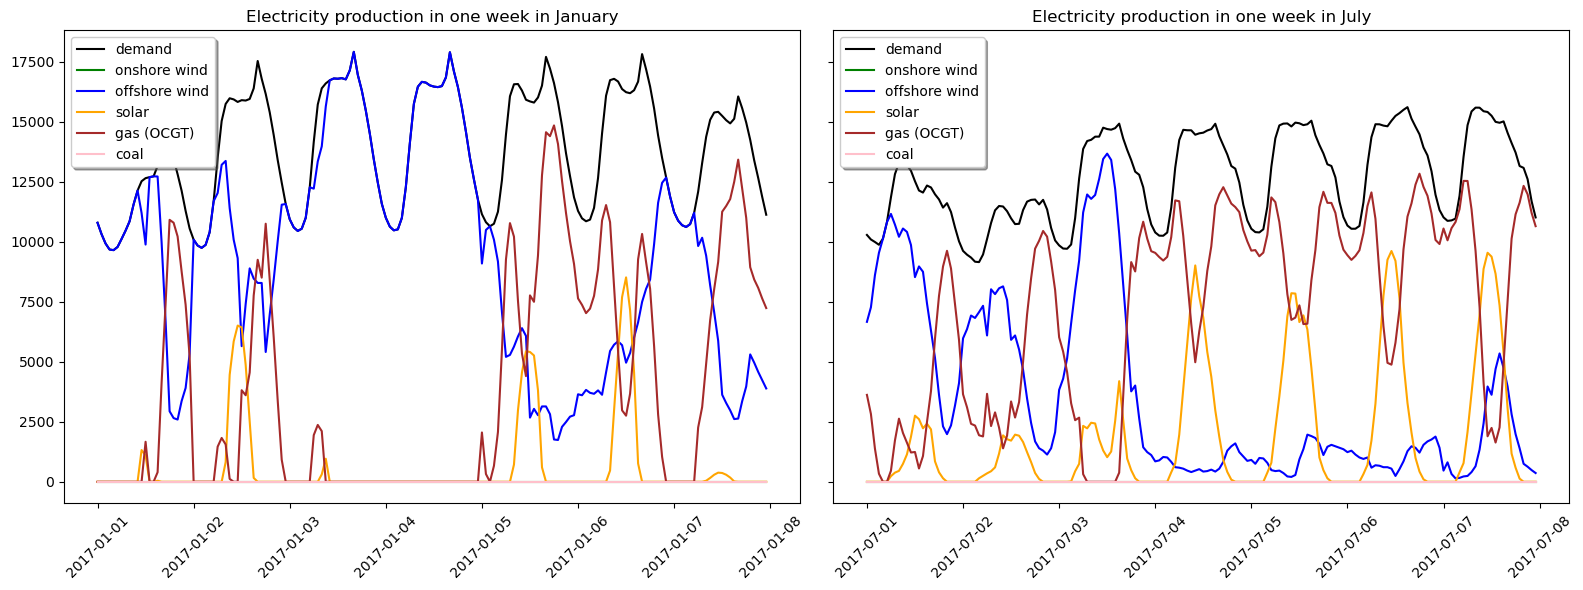

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='green', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='blue', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['OCGT'][0:168], color='brown', label='gas (OCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='pink', label='coal')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='green', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='blue', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['OCGT'][4344:4512], color='brown', label='gas (OCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='pink', label='coal')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Electricity mix

Text(0.5, 1.07, 'Electricity mix')

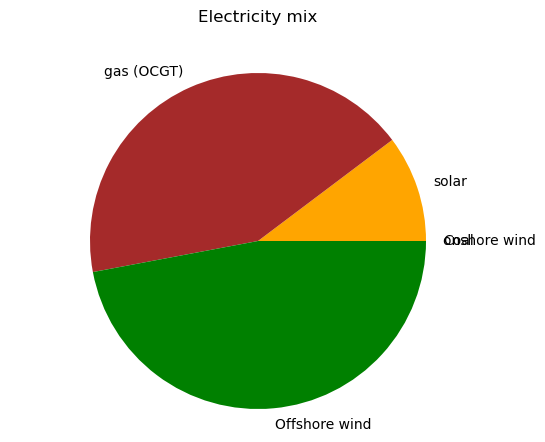

In [144]:
labels = ['onshore wind',
          'solar',
          'gas (OCGT)',
          'Offshore wind',
          'Coal']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'black']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

## CO2 limit 

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]
INFO:linopy.io: Writing time: 1.35s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-d74ws5xh.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-d74ws5xh.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 96366 rows, 43805 columns, 188339 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 188339 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 96366 rows, 43805 columns and 188339 nonzeros


INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 188339 nonzeros


Model fingerprint: 0x6400109c


INFO:gurobipy:Model fingerprint: 0x6400109c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [6e+01, 8e+04]


INFO:gurobipy:  Objective range  [6e+01, 8e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e+03, 4e+07]


INFO:gurobipy:  RHS range        [9e+03, 4e+07]


Presolve removed 48191 rows and 4386 columns


INFO:gurobipy:Presolve removed 48191 rows and 4386 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 48175 rows, 39419 columns, 135762 nonzeros


INFO:gurobipy:Presolved: 48175 rows, 39419 columns, 135762 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.051e+05


INFO:gurobipy: AA' NZ     : 1.051e+05


 Factor NZ  : 4.248e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.248e+05 (roughly 40 MB of memory)


 Factor Ops : 3.893e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.893e+06 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.51353807e+12  0.00000000e+00  1.95e+10 0.00e+00  1.26e+09     0s


INFO:gurobipy:   0   2.51353807e+12  0.00000000e+00  1.95e+10 0.00e+00  1.26e+09     0s


   1   2.55057132e+12 -1.47290911e+11  3.41e+09 2.08e+02  2.84e+08     0s


INFO:gurobipy:   1   2.55057132e+12 -1.47290911e+11  3.41e+09 2.08e+02  2.84e+08     0s


   2   1.75087098e+12 -1.82117815e+11  1.87e+08 8.15e-10  2.24e+07     0s


INFO:gurobipy:   2   1.75087098e+12 -1.82117815e+11  1.87e+08 8.15e-10  2.24e+07     0s


   3   2.98335725e+11 -2.68055238e+11  9.02e+03 6.62e-10  5.48e+06     0s


INFO:gurobipy:   3   2.98335725e+11 -2.68055238e+11  9.02e+03 6.62e-10  5.48e+06     0s


   4   1.10367019e+11 -1.33138481e+11  2.84e+03 3.49e-10  2.19e+06     0s


INFO:gurobipy:   4   1.10367019e+11 -1.33138481e+11  2.84e+03 3.49e-10  2.19e+06     0s


   5   6.27685273e+10 -1.08005772e+11  1.44e+03 7.72e-11  1.50e+06     0s


INFO:gurobipy:   5   6.27685273e+10 -1.08005772e+11  1.44e+03 7.72e-11  1.50e+06     0s


   6   3.40901263e+10 -6.73928892e+10  6.30e+02 8.31e-10  8.75e+05     0s


INFO:gurobipy:   6   3.40901263e+10 -6.73928892e+10  6.30e+02 8.31e-10  8.75e+05     0s


   7   1.77314529e+10 -9.00368672e+09  2.31e+02 1.24e-09  2.28e+05     1s


INFO:gurobipy:   7   1.77314529e+10 -9.00368672e+09  2.31e+02 1.24e-09  2.28e+05     1s


   8   1.10487896e+10 -3.01432144e+08  9.73e+01 1.22e-10  9.67e+04     1s


INFO:gurobipy:   8   1.10487896e+10 -3.01432144e+08  9.73e+01 1.22e-10  9.67e+04     1s


   9   9.95338618e+09  3.34008146e+09  7.71e+01 4.66e-10  5.63e+04     1s


INFO:gurobipy:   9   9.95338618e+09  3.34008146e+09  7.71e+01 4.66e-10  5.63e+04     1s


  10   8.83523623e+09  3.98734735e+09  5.85e+01 5.97e-10  4.12e+04     1s


INFO:gurobipy:  10   8.83523623e+09  3.98734735e+09  5.85e+01 5.97e-10  4.12e+04     1s


  11   8.41043669e+09  4.43906609e+09  5.04e+01 2.36e-10  3.38e+04     1s


INFO:gurobipy:  11   8.41043669e+09  4.43906609e+09  5.04e+01 2.36e-10  3.38e+04     1s


  12   7.83401479e+09  4.93479603e+09  3.89e+01 4.09e-10  2.46e+04     1s


INFO:gurobipy:  12   7.83401479e+09  4.93479603e+09  3.89e+01 4.09e-10  2.46e+04     1s


  13   6.54654358e+09  5.29836928e+09  1.30e+01 2.79e-10  1.06e+04     1s


INFO:gurobipy:  13   6.54654358e+09  5.29836928e+09  1.30e+01 2.79e-10  1.06e+04     1s


  14   6.16501882e+09  5.64537764e+09  5.60e+00 5.51e-10  4.41e+03     1s


INFO:gurobipy:  14   6.16501882e+09  5.64537764e+09  5.60e+00 5.51e-10  4.41e+03     1s


  15   6.03062263e+09  5.75452565e+09  3.29e+00 9.56e-10  2.34e+03     1s


INFO:gurobipy:  15   6.03062263e+09  5.75452565e+09  3.29e+00 9.56e-10  2.34e+03     1s


  16   5.94119018e+09  5.78010630e+09  1.82e+00 2.46e-10  1.37e+03     1s


INFO:gurobipy:  16   5.94119018e+09  5.78010630e+09  1.82e+00 2.46e-10  1.37e+03     1s


  17   5.88994640e+09  5.79820259e+09  9.96e-01 9.97e-10  7.78e+02     1s


INFO:gurobipy:  17   5.88994640e+09  5.79820259e+09  9.96e-01 9.97e-10  7.78e+02     1s


  18   5.86819551e+09  5.80689099e+09  6.60e-01 4.95e-10  5.20e+02     1s


INFO:gurobipy:  18   5.86819551e+09  5.80689099e+09  6.60e-01 4.95e-10  5.20e+02     1s


  19   5.84494287e+09  5.81369811e+09  3.03e-01 6.80e-10  2.65e+02     1s


INFO:gurobipy:  19   5.84494287e+09  5.81369811e+09  3.03e-01 6.80e-10  2.65e+02     1s


  20   5.83181400e+09  5.82052116e+09  1.07e-01 1.09e-09  9.57e+01     1s


INFO:gurobipy:  20   5.83181400e+09  5.82052116e+09  1.07e-01 1.09e-09  9.57e+01     1s


  21   5.82808685e+09  5.82185877e+09  5.63e-02 6.08e-10  5.28e+01     1s


INFO:gurobipy:  21   5.82808685e+09  5.82185877e+09  5.63e-02 6.08e-10  5.28e+01     1s


  22   5.82720678e+09  5.82257328e+09  4.43e-02 1.53e-12  3.93e+01     1s


INFO:gurobipy:  22   5.82720678e+09  5.82257328e+09  4.43e-02 1.53e-12  3.93e+01     1s


  23   5.82501984e+09  5.82305746e+09  1.50e-02 1.18e-09  1.66e+01     1s


INFO:gurobipy:  23   5.82501984e+09  5.82305746e+09  1.50e-02 1.18e-09  1.66e+01     1s


  24   5.82416949e+09  5.82348009e+09  4.47e-03 1.16e-09  5.84e+00     1s


INFO:gurobipy:  24   5.82416949e+09  5.82348009e+09  4.47e-03 1.16e-09  5.84e+00     1s


  25   5.82389699e+09  5.82363884e+09  1.26e-03 2.64e-09  2.19e+00     1s


INFO:gurobipy:  25   5.82389699e+09  5.82363884e+09  1.26e-03 2.64e-09  2.19e+00     1s


  26   5.82382884e+09  5.82375809e+09  4.78e-04 7.87e-10  5.99e-01     2s


INFO:gurobipy:  26   5.82382884e+09  5.82375809e+09  4.78e-04 7.87e-10  5.99e-01     2s


  27   5.82378515e+09  5.82378431e+09  7.98e-06 6.29e-10  7.12e-03     2s


INFO:gurobipy:  27   5.82378515e+09  5.82378431e+09  7.98e-06 6.29e-10  7.12e-03     2s


  28   5.82378460e+09  5.82378460e+09  1.03e-07 1.12e-10  7.12e-06     2s


INFO:gurobipy:  28   5.82378460e+09  5.82378460e+09  1.03e-07 1.12e-10  7.12e-06     2s


  29   5.82378460e+09  5.82378460e+09  8.95e-10 8.15e-10  7.17e-12     2s


INFO:gurobipy:  29   5.82378460e+09  5.82378460e+09  8.95e-10 8.15e-10  7.17e-12     2s


INFO:gurobipy:


Barrier solved model in 29 iterations and 1.72 seconds (0.55 work units)


INFO:gurobipy:Barrier solved model in 29 iterations and 1.72 seconds (0.55 work units)


Optimal objective 5.82378460e+09


INFO:gurobipy:Optimal objective 5.82378460e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   17552 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   17552 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    1000 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    1000 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4478721e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4478721e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7810    5.8237846e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    7810    5.8237846e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 7810 iterations and 2.08 seconds (0.62 work units)


INFO:gurobipy:Solved in 7810 iterations and 2.08 seconds (0.62 work units)


Optimal objective  5.823784597e+09


INFO:gurobipy:Optimal objective  5.823784597e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 5.82e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Text(0.5, 1.07, 'Electricity mix')

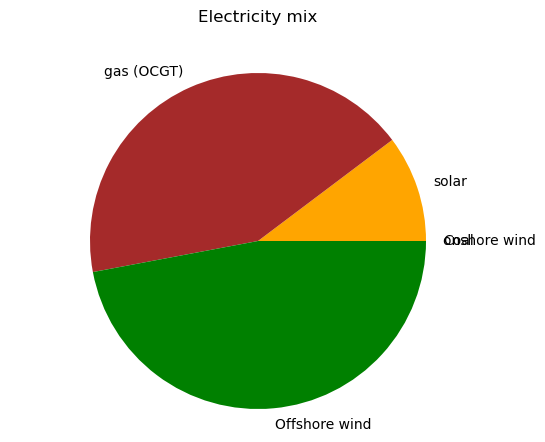

In [145]:
co2_limit=38564880#tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)
network.optimize(solver_name='gurobi')
labels = ['onshore wind',
          'solar',
          'gas (OCGT)',
          'Offshore wind',
          'Coal']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'black']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [146]:
print(network.objective/1000000) #in 10^6 €

5823.784596568709


Part C. Plotting Average Capacity and variability for every generator

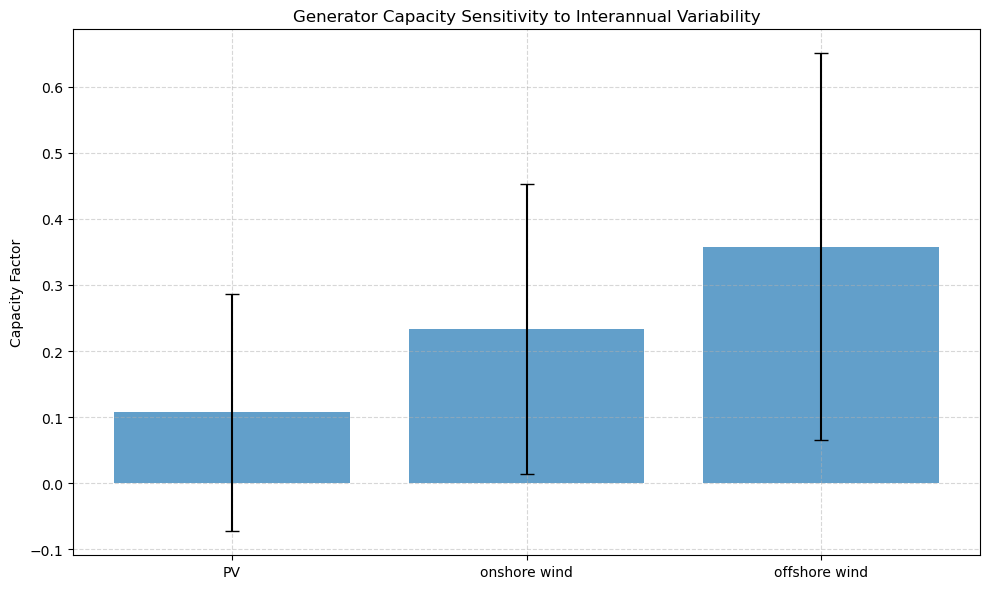

In [147]:
#calculating the average capacity for each generator using different years
Country = 'NLD'

data_pv = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
data_pv.index = pd.to_datetime(data_pv.index)
CF_pv = data_pv[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

data_onshore_wind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
data_onshore_wind.index = pd.to_datetime(data_onshore_wind.index)
CF_onshore_wind = data_onshore_wind[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

data_offshore_wind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
data_offshore_wind.index = pd.to_datetime(data_offshore_wind.index)
CF_offshore_wind = data_offshore_wind[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

CF_all = pd.concat([CF_pv.rename('PV'),
                    CF_onshore_wind.rename('onshore wind'),
                    CF_offshore_wind.rename('offshore wind')], axis=1)

average = CF_all.mean()
std_dev = CF_all.std()

plt.figure(figsize=(10, 6))
plt.bar(average.index, average.values, yerr=std_dev.values, capsize=5, alpha = 0.7)
plt.ylabel('Capacity Factor')
plt.title('Generator Capacity Sensitivity to Interannual Variability')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()






Part D. Adding Storage Technology

In [153]:
network.add("Carrier", "battery")
network.add("Carrier", "Pumped Hydro")

# add storage units (battery and pumped hydro)
network.add("StorageUnit", "battery", 
            bus="electricity bus",
            p_nom=250,
            max_hours=4,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=200000,
            marginal_cost=0,
            carrier="battery",
            overwrite = True)

network.add("StorageUnit", "Pumped Hydro", 
            bus="electricity bus",
            p_nom=500,
            p_nom_extendable = True,
            max_hours=12,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=2000000,
            marginal_cost=0,
            carrier="Pumped Hydro",
            overwrite = True)


Index(['Pumped Hydro'], dtype='object')

In [149]:
network.storage_units.head(3)

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
battery,electricity bus,PQ,,2500.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,4.0,0.9,0.9,0.0,0.0,0.0
Pumped Hydro,electricity bus,PQ,,5000.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,12.0,0.9,0.9,0.0,0.0,0.0


In [154]:
network.optimize(solver_name='gurobi')

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]
INFO:linopy.io: Writing time: 3.42s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-0aktwdke.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-0aktwdke.lp


Reading time = 0.70 seconds


INFO:gurobipy:Reading time = 0.70 seconds


obj: 219008 rows, 96368 columns, 451139 nonzeros


INFO:gurobipy:obj: 219008 rows, 96368 columns, 451139 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 219008 rows, 96368 columns and 451139 nonzeros


INFO:gurobipy:Optimize a model with 219008 rows, 96368 columns and 451139 nonzeros


Model fingerprint: 0x485cffb1


INFO:gurobipy:Model fingerprint: 0x485cffb1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+01]


INFO:gurobipy:  Matrix range     [1e-03, 1e+01]


  Objective range  [1e+00, 2e+06]


INFO:gurobipy:  Objective range  [1e+00, 2e+06]


  Bounds range     [1e+09, 1e+09]


INFO:gurobipy:  Bounds range     [1e+09, 1e+09]


  RHS range        [9e+03, 4e+07]


INFO:gurobipy:  RHS range        [9e+03, 4e+07]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 100755 rows and 4389 columns


INFO:gurobipy:Presolve removed 100755 rows and 4389 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 118253 rows, 91979 columns, 345996 nonzeros


INFO:gurobipy:Presolved: 118253 rows, 91979 columns, 345996 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.09s


INFO:gurobipy:Ordering time: 0.09s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.978e+05


INFO:gurobipy: AA' NZ     : 2.978e+05


 Factor NZ  : 2.039e+06 (roughly 100 MB of memory)


INFO:gurobipy: Factor NZ  : 2.039e+06 (roughly 100 MB of memory)


 Factor Ops : 3.892e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.892e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.88358011e+12 -1.05000000e+09  1.39e+10 0.00e+00  2.41e+09     1s


INFO:gurobipy:   0   2.88358011e+12 -1.05000000e+09  1.39e+10 0.00e+00  2.41e+09     1s


   1   6.32021921e+12 -2.43849898e+11  1.87e+09 3.70e+02  7.92e+08     1s


INFO:gurobipy:   1   6.32021921e+12 -2.43849898e+11  1.87e+09 3.70e+02  7.92e+08     1s


   2   6.17870760e+12 -3.72143830e+11  2.68e+07 2.16e+01  7.45e+07     2s


INFO:gurobipy:   2   6.17870760e+12 -3.72143830e+11  2.68e+07 2.16e+01  7.45e+07     2s


   3   1.65002485e+12 -3.72256727e+10  8.38e+04 1.40e+00  1.06e+07     2s


INFO:gurobipy:   3   1.65002485e+12 -3.72256727e+10  8.38e+04 1.40e+00  1.06e+07     2s


   4   3.34536468e+11 -6.07337278e+09  5.66e+03 2.85e-01  1.95e+06     2s


INFO:gurobipy:   4   3.34536468e+11 -6.07337278e+09  5.66e+03 2.85e-01  1.95e+06     2s


   5   2.63541319e+11 -5.56941203e+09  3.25e+00 2.81e-01  1.54e+06     2s


INFO:gurobipy:   5   2.63541319e+11 -5.56941203e+09  3.25e+00 2.81e-01  1.54e+06     2s


   6   1.76594230e+11 -5.62232858e+09  2.14e+00 2.28e-01  1.03e+06     2s


INFO:gurobipy:   6   1.76594230e+11 -5.62232858e+09  2.14e+00 2.28e-01  1.03e+06     2s


   7   6.42524107e+10 -4.34123842e+09  7.56e-01 1.16e-01  3.81e+05     3s


INFO:gurobipy:   7   6.42524107e+10 -4.34123842e+09  7.56e-01 1.16e-01  3.81e+05     3s


   8   2.95679759e+10 -1.19165195e+09  3.30e-01 2.96e-10  1.69e+05     3s


INFO:gurobipy:   8   2.95679759e+10 -1.19165195e+09  3.30e-01 2.96e-10  1.69e+05     3s


   9   2.06290507e+10  9.99769414e+08  2.10e-01 2.20e-10  1.07e+05     3s


INFO:gurobipy:   9   2.06290507e+10  9.99769414e+08  2.10e-01 2.20e-10  1.07e+05     3s


  10   1.34297173e+10  2.14498477e+09  1.15e-01 6.03e-10  6.16e+04     3s


INFO:gurobipy:  10   1.34297173e+10  2.14498477e+09  1.15e-01 6.03e-10  6.16e+04     3s


  11   9.10029877e+09  2.82445270e+09  5.66e-02 1.65e-09  3.42e+04     3s


INFO:gurobipy:  11   9.10029877e+09  2.82445270e+09  5.66e-02 1.65e-09  3.42e+04     3s


  12   7.07938296e+09  3.48078996e+09  2.96e-02 9.55e-10  1.96e+04     3s


INFO:gurobipy:  12   7.07938296e+09  3.48078996e+09  2.96e-02 9.55e-10  1.96e+04     3s


  13   6.49518700e+09  3.76268647e+09  2.22e-02 3.33e-10  1.49e+04     4s


INFO:gurobipy:  13   6.49518700e+09  3.76268647e+09  2.22e-02 3.33e-10  1.49e+04     4s


  14   6.18343090e+09  3.97330686e+09  1.80e-02 1.06e-09  1.20e+04     4s


INFO:gurobipy:  14   6.18343090e+09  3.97330686e+09  1.80e-02 1.06e-09  1.20e+04     4s


  15   5.98022779e+09  4.14679984e+09  1.53e-02 6.37e-10  9.98e+03     4s


INFO:gurobipy:  15   5.98022779e+09  4.14679984e+09  1.53e-02 6.37e-10  9.98e+03     4s


  16   5.62414908e+09  4.40042590e+09  9.58e-03 1.88e-09  6.66e+03     4s


INFO:gurobipy:  16   5.62414908e+09  4.40042590e+09  9.58e-03 1.88e-09  6.66e+03     4s


  17   5.35208384e+09  4.49628987e+09  6.22e-03 5.75e-10  4.66e+03     4s


INFO:gurobipy:  17   5.35208384e+09  4.49628987e+09  6.22e-03 5.75e-10  4.66e+03     4s


  18   5.23337938e+09  4.53446483e+09  4.85e-03 6.97e-10  3.80e+03     4s


INFO:gurobipy:  18   5.23337938e+09  4.53446483e+09  4.85e-03 6.97e-10  3.80e+03     4s


  19   5.19800878e+09  4.62613470e+09  4.42e-03 1.72e-09  3.11e+03     5s


INFO:gurobipy:  19   5.19800878e+09  4.62613470e+09  4.42e-03 1.72e-09  3.11e+03     5s


  20   5.07197425e+09  4.66680244e+09  3.03e-03 1.23e-09  2.21e+03     5s


INFO:gurobipy:  20   5.07197425e+09  4.66680244e+09  3.03e-03 1.23e-09  2.21e+03     5s


  21   4.98890546e+09  4.70263998e+09  2.13e-03 1.26e-09  1.56e+03     5s


INFO:gurobipy:  21   4.98890546e+09  4.70263998e+09  2.13e-03 1.26e-09  1.56e+03     5s


  22   4.93920531e+09  4.72484552e+09  1.61e-03 3.03e-09  1.17e+03     5s


INFO:gurobipy:  22   4.93920531e+09  4.72484552e+09  1.61e-03 3.03e-09  1.17e+03     5s


  23   4.90346172e+09  4.74217517e+09  1.24e-03 2.27e-09  8.78e+02     5s


INFO:gurobipy:  23   4.90346172e+09  4.74217517e+09  1.24e-03 2.27e-09  8.78e+02     5s


  24   4.85751749e+09  4.74763878e+09  7.76e-04 5.10e-09  5.98e+02     5s


INFO:gurobipy:  24   4.85751749e+09  4.74763878e+09  7.76e-04 5.10e-09  5.98e+02     5s


  25   4.84700211e+09  4.75193426e+09  6.74e-04 5.31e-09  5.17e+02     5s


INFO:gurobipy:  25   4.84700211e+09  4.75193426e+09  6.74e-04 5.31e-09  5.17e+02     5s


  26   4.82446048e+09  4.76026838e+09  4.55e-04 9.90e-09  3.49e+02     6s


INFO:gurobipy:  26   4.82446048e+09  4.76026838e+09  4.55e-04 9.90e-09  3.49e+02     6s


  27   4.81116180e+09  4.76536394e+09  3.30e-04 1.12e-08  2.49e+02     6s


INFO:gurobipy:  27   4.81116180e+09  4.76536394e+09  3.30e-04 1.12e-08  2.49e+02     6s


  28   4.79847044e+09  4.76776740e+09  2.13e-04 9.41e-09  1.67e+02     6s


INFO:gurobipy:  28   4.79847044e+09  4.76776740e+09  2.13e-04 9.41e-09  1.67e+02     6s


  29   4.79793899e+09  4.76865116e+09  2.06e-04 7.84e-09  1.59e+02     6s


INFO:gurobipy:  29   4.79793899e+09  4.76865116e+09  2.06e-04 7.84e-09  1.59e+02     6s


  30   4.78874641e+09  4.76951480e+09  1.21e-04 1.03e-08  1.05e+02     6s


INFO:gurobipy:  30   4.78874641e+09  4.76951480e+09  1.21e-04 1.03e-08  1.05e+02     6s


  31   4.78153996e+09  4.77133663e+09  5.99e-05 6.88e-09  5.55e+01     6s


INFO:gurobipy:  31   4.78153996e+09  4.77133663e+09  5.99e-05 6.88e-09  5.55e+01     6s


  32   4.77925879e+09  4.77246738e+09  4.09e-05 3.07e-09  3.70e+01     7s


INFO:gurobipy:  32   4.77925879e+09  4.77246738e+09  4.09e-05 3.07e-09  3.70e+01     7s


  33   4.77758289e+09  4.77294843e+09  2.77e-05 3.82e-09  2.52e+01     7s


INFO:gurobipy:  33   4.77758289e+09  4.77294843e+09  2.77e-05 3.82e-09  2.52e+01     7s


  34   4.77593879e+09  4.77332947e+09  1.57e-05 1.42e-08  1.42e+01     7s


INFO:gurobipy:  34   4.77593879e+09  4.77332947e+09  1.57e-05 1.42e-08  1.42e+01     7s


  35   4.77519818e+09  4.77345965e+09  1.03e-05 1.03e-08  9.46e+00     7s


INFO:gurobipy:  35   4.77519818e+09  4.77345965e+09  1.03e-05 1.03e-08  9.46e+00     7s


  36   4.77452569e+09  4.77361210e+09  5.19e-06 1.35e-08  4.97e+00     7s


INFO:gurobipy:  36   4.77452569e+09  4.77361210e+09  5.19e-06 1.35e-08  4.97e+00     7s


  37   4.77430574e+09  4.77366461e+09  3.64e-06 1.40e-08  3.49e+00     8s


INFO:gurobipy:  37   4.77430574e+09  4.77366461e+09  3.64e-06 1.40e-08  3.49e+00     8s


  38   4.77384452e+09  4.77377499e+09  6.94e-07 1.22e-08  3.78e-01     8s


INFO:gurobipy:  38   4.77384452e+09  4.77377499e+09  6.94e-07 1.22e-08  3.78e-01     8s


  39   4.77378512e+09  4.77378450e+09  9.32e-07 1.31e-08  3.35e-03     8s


INFO:gurobipy:  39   4.77378512e+09  4.77378450e+09  9.32e-07 1.31e-08  3.35e-03     8s


  40   4.77378460e+09  4.77378460e+09  3.01e-08 2.99e-09  5.98e-09     8s


INFO:gurobipy:  40   4.77378460e+09  4.77378460e+09  3.01e-08 2.99e-09  5.98e-09     8s


INFO:gurobipy:


Barrier solved model in 40 iterations and 8.00 seconds (2.73 work units)


INFO:gurobipy:Barrier solved model in 40 iterations and 8.00 seconds (2.73 work units)


Optimal objective 4.77378460e+09


INFO:gurobipy:Optimal objective 4.77378460e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   87623 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   87623 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     999 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:     999 PPushes remaining with PInf 0.0000000e+00                 8s


       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4654661e-09      9s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4654661e-09      9s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   44197    4.7737846e+09   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:   44197    4.7737846e+09   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Solved in 44197 iterations and 8.84 seconds (2.92 work units)


INFO:gurobipy:Solved in 44197 iterations and 8.84 seconds (2.92 work units)


Optimal objective  4.773784597e+09


INFO:gurobipy:Optimal objective  4.773784597e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96368 primals, 219008 duals
Objective: 4.77e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [155]:
p_nom_opt_batt = network.storage_units.loc["battery", "p_nom_opt"]
p_nom_opt_pump = network.storage_units.loc["Pumped Hydro", "p_nom_opt"]
print(p_nom_opt_batt)
print(p_nom_opt_pump)

0.0
0.0


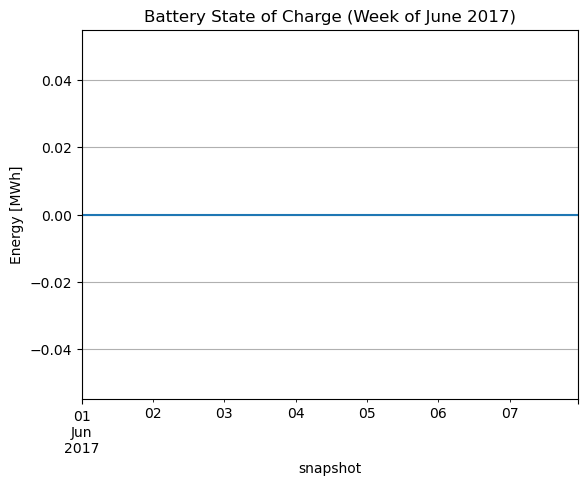

In [156]:
network.storage_units_t.state_of_charge["battery"].loc["2017-06-01":"2017-06-07"].plot()
plt.title("Battery State of Charge (Week of June 2017)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()
